# Implementation 

This notebook is structured in the following outline : 
- implementation of uSCION and SCION
- experiment A : performance comparison of SCION/uSCION vs Adam/SGD/Muon over Fashion-MNIST
- experiment B : hyperparameters transfer depending on the width on SVHN
- experiment C : norm control SCG vs uSCG 

In [23]:
import os, math, time, random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

print("torch:", torch.__version__)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

torch: 2.10.0


device(type='mps')

In [24]:
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(0)

## SCION / uSCION implementation

We implement two variants:

- uSCION (unconstrained):  $x \leftarrow x + \gamma * LMO(d)$ 
- SCION (constrained): $x \leftarrow (1-\gamma) x + \gamma * \rho * LMO(d)$

where:
- d is a momentum  stochastic gradient direction (sum of past gradients)
- LMO(d) returns an extreme point of the unit ball of a chosen norm, we implement:
  - sign-LMO for vector-like parameters (bias, LayerNorm, etc.)
  - spectral/polar-LMO for 2D matrix parameters

- $\rho$ is an optional radius (default 1.0)


In [ ]:
@torch.no_grad()
def lmo_sign(g: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    lmo sign operator
    """
    return -torch.sign(g).clamp(min=-1.0, max=1.0)

@torch.no_grad()
def lmo_rms(g: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    n = g.numel()
    if n == 0:
        return torch.zeros_like(g)
    rms = torch.linalg.norm(g.flatten(), ord=2) / math.sqrt(n)
    if rms < eps:
        return torch.zeros_like(g)
    return -(g / (rms + eps))

@torch.no_grad()
def newton_schulz_polar_factor(G: torch.Tensor, iters: int = 5, eps: float = 1e-6) -> torch.Tensor:
    """
    Approximate polar factor Q of matrix G: G = Q H with Q ~ orthogonal-ish.
    Works for rectangular matrices using Gram matrix.
    Runs iterations in fp32 for stability, then casts back.
    """
    assert G.ndim == 2
    dtype_in = G.dtype
    device = G.device


    X0 = G.float()

    fro = torch.linalg.norm(X0, ord="fro")
    if fro < eps:
        return torch.zeros_like(G)

    X = X0 / (fro + eps)
    m, n = X.shape

    if m >= n:
        # left polar: Q = X (X^T X)^(-1/2)
        A = X.T @ X  # (n,n)
        Af = torch.linalg.norm(A, ord="fro")
        A = A / (Af + eps)

        Y = A
        Z = torch.eye(n, device=device, dtype=torch.float32)
        I = torch.eye(n, device=device, dtype=torch.float32)

        for _ in range(iters):
            Tm = 0.5 * (3.0 * I - Z @ Y)
            Y = Y @ Tm
            Z = Tm @ Z

        inv_sqrt = Z
        Q = X @ inv_sqrt  # (m,n)
    else:
        # wide case: Q = (X X^T)^(-1/2) X
        A = X @ X.T  
        Af = torch.linalg.norm(A, ord="fro")
        A = A / (Af + eps)

        Y = A
        Z = torch.eye(m, device=device, dtype=torch.float32)
        I = torch.eye(m, device=device, dtype=torch.float32)

        for _ in range(iters):
            Tm = 0.5 * (3.0 * I - Z @ Y)
            Y = Y @ Tm
            Z = Tm @ Z

        inv_sqrt = Z
        Q = inv_sqrt @ X  # (m,n)

    return Q.to(dtype_in)

@torch.no_grad()
def lmo_polar(G: torch.Tensor, iters: int = 5) -> torch.Tensor:
    Q = newton_schulz_polar_factor(G, iters=iters)
    return -Q

@torch.no_grad()
def scion_rho_for_param(p: torch.Tensor, first_layer_heuristic: bool = True) -> float:
    """
    SCION-style layerwise scaling:
      rho = sqrt(d_out / d_in_eff)

    - Linear weight: (d_out, d_in)
    - Conv weight:   (d_out, d_in, kH, kW) -> d_in_eff = d_in*kH*kW
    - Otherwise: 1.0

    Heuristic for "first image layer": for Conv with in_ch in {1,3},
    use rho = max(1, sqrt(d_out/d_in_eff)).
    """
    if p.ndim == 2:
        d_out, d_in = p.shape
        rho = math.sqrt(float(d_out) / max(1.0, float(d_in)))
        return rho

    if p.ndim == 4:
        d_out, d_in, kH, kW = p.shape
        d_in_eff = float(d_in * kH * kW)
        rho = math.sqrt(float(d_out) / max(1.0, d_in_eff))

        if first_layer_heuristic and int(d_in) in (1, 3):
            rho = max(1.0, rho)
        return rho

    return 1.0

@torch.no_grad()
def scion_lmo_for_param(g: torch.Tensor, polar_iters: int = 5, vector_lmo: str = "rms") -> torch.Tensor:
    """
    Returns LMO direction s with the right "geometry" depending on tensor shape:
      - 2D: polar LMO (spectral ball)
      - 4D conv: reshape to (d_out, d_in*kH*kW), polar LMO, reshape back
      - else: vector LMO (RMS by default; can switch to sign)
    """
    if g.ndim == 2:
        return lmo_polar(g, iters=polar_iters)

    if g.ndim == 4:
        d_out, d_in, kH, kW = g.shape
        Gm = g.reshape(d_out, d_in * kH * kW)
        Sm = lmo_polar(Gm, iters=polar_iters)
        return Sm.reshape_as(g)

    # biases, LayerNorm, embeddings rows etc.
    if vector_lmo.lower() == "sign":
        return lmo_sign(g)
    return lmo_rms(g)


@torch.no_grad()
def lmo_dispatch(g: torch.Tensor, polar_iters: int = 5) -> torch.Tensor:
    if g.ndim == 2:
        # used polar for weight matrices 
        return lmo_polar(g, iters=polar_iters)
    else:
        # use sign for vectors 
        return lmo_sign(g)

In [ ]:
class SCION(torch.optim.Optimizer):
    """
    SCION / uSCION optimizer 
    """
    def __init__(
        self,
        params,
        lr: float = 1e-2, # learning rate gamma 
        momentum: float = 0.9, # momentum beta for accumulated gradient 
        constrained: bool = False, # True for SCION, False for uSCIOn
        radius: float = 1.0, # radius for the scaling of LMO output in constrained mode 
        polar_iters: int = 5, # Newton–Schulz iterations used for matrix LMO
        vector_lmo: str = "rms",          # "rms" (default) or "sign"
        first_layer_heuristic: bool = True,
        weight_decay : float = 0.0, # not implemented 
    ):
        if not (0.0 <= momentum < 1.0):
            raise ValueError("momentum must be in [0,1)")
        defaults = dict(
            lr=lr,
            momentum=momentum,
            constrained=constrained,
            radius=radius,
            polar_iters=polar_iters,
            vector_lmo=vector_lmo,
            first_layer_heuristic=first_layer_heuristic,
        )
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            beta = group["momentum"]
            constrained = group["constrained"]
            rho = group["radius"]
            polar_iters = group["polar_iters"]
            vector_lmo = group["vector_lmo"]
            first_layer_heuristic = group["first_layer_heuristic"]


            for p in group["params"]:
                if p.grad is None:
                    continue

                g = p.grad


                st = self.state[p]
                if "buf" not in st:
                    st["buf"] = torch.zeros_like(g)

                buf = st["buf"]
                # EMA gradient accumulator (alpha = 1-beta)
                buf.mul_(beta).add_(g, alpha=(1.0 - beta))
                d = buf

                # SCION rho_l scaling (layerwise)
                rho_l = scion_rho_for_param(p, first_layer_heuristic=first_layer_heuristic)

                # LMO direction adapted to tensor shape
                s = scion_lmo_for_param(d, polar_iters=polar_iters, vector_lmo=vector_lmo)

                if constrained:
                    # x <- (1-gamma)x + gamma * rho_l * s
                    p.mul_(1.0 - lr).add_(s, alpha=lr * rho_l)
                else:
                    # x <- x + gamma * rho_l * s
                    p.add_(s, alpha=lr * rho_l)

        return loss



In [27]:
def make_optimizer(name: str, model: nn.Module, lr: float, wd: float = 0.0, momentum: float = 0.9):
    """
    Utils to select the optimizer for the experiments of the notebook
    """
    name = name.lower()

    if name == "adamw":
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd, nesterov=True)

    if name == "muon":
        if hasattr(torch.optim, "Muon"):
            mat_params, other_params = [], []
            for p in model.parameters():
                (mat_params if p.ndim == 2 else other_params).append(p)
            opt_muon = torch.optim.Muon(mat_params, lr=lr, weight_decay=wd)
            opt_other = torch.optim.AdamW(other_params, lr=lr, weight_decay=wd)
            return (opt_muon, opt_other)
        else:
            print("ERROR: torch.optim.Muon not found : using AdamW")
            return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    if name == "scion":
        return SCION(model.parameters(), lr=lr, momentum=momentum, constrained=True,
                     polar_iters=5, weight_decay=wd, vector_lmo="rms")

    if name == "uscion":
        return SCION(model.parameters(), lr=lr, momentum=momentum, constrained=False,
                     polar_iters=5, weight_decay=wd, vector_lmo="rms")

    raise ValueError(f"Unknown optimizer: {name}")

In [28]:
class SmallCNN(nn.Module):
    """
    small model for experimentation over vision datasets
    """
    def __init__(self, in_ch: int, num_classes: int, width: int = 64, dropout: float = 0.1):
        super().__init__()
        w = width
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, w, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(w, w, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(w, 2*w, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(2*w, 2*w, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d(1),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(2*w, num_classes)
        )

    def forward(self, x):
        x = self.net(x)
        return self.head(x)

Utils for dataset loading : 

In [29]:
def get_fashion_mnist(batch_size: int = 128, num_workers: int = 0):
    tfm = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,))
    ])
    train = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=tfm)
    test  = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=tfm)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader

def get_svhn(batch_size: int = 128, num_workers: int = 0):
    tfm = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ])
    train = torchvision.datasets.SVHN(root="./data", split="train", download=True, transform=tfm)
    test  = torchvision.datasets.SVHN(root="./data", split="test",  download=True, transform=tfm)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader

Utils for training :

In [34]:
@torch.no_grad()
def accuracy(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

def run_epoch(model, loader, optimizer, train: bool = True):
    model.train(train)
    total_loss = 0.0
    total_acc = 0.0
    n = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            # zero grad
            if isinstance(optimizer, tuple):
                for opt in optimizer:
                    opt.zero_grad(set_to_none=True)
            else:
                optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        if train:
            loss.backward()
            if isinstance(optimizer, tuple):
                for opt in optimizer:
                    opt.step()
            else:
                optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

def fit(model, train_loader, test_loader, optimizer, epochs: int = 10):
    history = []
    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer, train=True)
        te_loss, te_acc = run_epoch(model, test_loader, optimizer, train=False)
        dt = time.time() - t0
        history.append(dict(epoch=ep, train_loss=tr_loss, train_acc=tr_acc, test_loss=te_loss, test_acc=te_acc, sec=dt))
        print(f"ep {ep:02d} | tr {tr_loss:.4f}/{tr_acc:.4f} | te {te_loss:.4f}/{te_acc:.4f} | {dt:.1f}s")
    return pd.DataFrame(history)

## Experiment A — Fashion-MNIST

Compare over the CNN model trained on Fashion-MNIST:
- AdamW
- SGD 
- Muon 
- SCION (constrained)
- uSCION (unconstrained)

Learning rate were find after some test to at least have a convergence. But further work might have been required to more tuning. 

In [47]:
set_seed(0)

train_loader, test_loader = get_fashion_mnist(batch_size=256)

def run_expA(optim_name: str, lr: float, wd: float = 0.0, momentum: float = 0.9, width: int = 64, epochs: int = 10):
    model = SmallCNN(in_ch=1, num_classes=10, width=width).to(device)
    opt = make_optimizer(optim_name, model, lr=lr, wd=wd, momentum=momentum)
    df = fit(model, train_loader, test_loader, opt, epochs=epochs)
    df["optimizer"] = optim_name
    df["lr"] = lr
    df["wd"] = wd
    df["width"] = width
    return df

dfs = []


In [49]:
# Reasonable starting points (adjust if needed)
configs = [
    ("adamw",  1e-3, 1e-4),
    ("sgd",    5e-2, 5e-4),
    ("muon",   2e-3, 1e-4),
]


for name, lr, wd in configs:
    print("\n===", name, "===")
    dfs.append(run_expA(name, lr=lr, wd=wd, epochs=20))


=== adamw ===
ep 01 | tr 1.0918/0.5893 | te 0.6999/0.7542 | 11.6s
ep 02 | tr 0.6299/0.7719 | te 0.5466/0.8082 | 11.0s
ep 03 | tr 0.5351/0.8059 | te 0.5203/0.8047 | 10.9s
ep 04 | tr 0.4774/0.8276 | te 0.4808/0.8253 | 12.0s
ep 05 | tr 0.4307/0.8435 | te 0.4128/0.8479 | 15.2s
ep 06 | tr 0.3928/0.8579 | te 0.4301/0.8426 | 13.4s
ep 07 | tr 0.3763/0.8626 | te 0.3757/0.8618 | 12.4s
ep 08 | tr 0.3552/0.8717 | te 0.3627/0.8710 | 10.9s
ep 09 | tr 0.3361/0.8786 | te 0.3270/0.8817 | 11.2s
ep 10 | tr 0.3207/0.8836 | te 0.3214/0.8860 | 11.6s
ep 11 | tr 0.3091/0.8885 | te 0.3280/0.8855 | 12.0s
ep 12 | tr 0.2997/0.8923 | te 0.3002/0.8937 | 11.5s
ep 13 | tr 0.2859/0.8968 | te 0.3053/0.8899 | 12.1s
ep 14 | tr 0.2784/0.8997 | te 0.2893/0.8978 | 12.4s
ep 15 | tr 0.2690/0.9040 | te 0.2789/0.8994 | 12.4s
ep 16 | tr 0.2622/0.9060 | te 0.3023/0.8871 | 14.2s
ep 17 | tr 0.2531/0.9089 | te 0.2691/0.9037 | 11.6s
ep 18 | tr 0.2474/0.9104 | te 0.2618/0.9051 | 11.4s
ep 19 | tr 0.2389/0.9135 | te 0.2707/0.8995 | 11.

In [48]:
configs = [
    ("scion",  0.003, 0.0),
    ("uscion", 3e-2, 0.0),
]

for name, lr, wd in configs:
    print("\n===", name, "===")
    dfs.append(run_expA(name, lr=lr, wd=wd, epochs=20))



=== scion ===
ep 01 | tr 2.2725/0.1808 | te 2.2414/0.1924 | 13.1s
ep 02 | tr 2.2208/0.2304 | te 2.2013/0.2612 | 12.0s
ep 03 | tr 2.1898/0.2504 | te 2.1795/0.2253 | 12.0s
ep 04 | tr 2.1717/0.2740 | te 2.1639/0.3220 | 12.2s
ep 05 | tr 2.1615/0.2840 | te 2.1574/0.2393 | 12.9s
ep 06 | tr 2.1571/0.2883 | te 2.1535/0.2961 | 12.2s
ep 07 | tr 2.1550/0.2782 | te 2.1517/0.3164 | 14.3s
ep 08 | tr 2.1532/0.2888 | te 2.1517/0.2512 | 14.4s
ep 09 | tr 2.1521/0.2877 | te 2.1498/0.3028 | 13.6s
ep 10 | tr 2.1515/0.2954 | te 2.1514/0.2848 | 12.5s
ep 11 | tr 2.1514/0.2824 | te 2.1504/0.2989 | 11.8s
ep 12 | tr 2.1513/0.2915 | te 2.1494/0.2463 | 12.6s
ep 13 | tr 2.1517/0.2963 | te 2.1511/0.2443 | 13.9s
ep 14 | tr 2.1513/0.2834 | te 2.1497/0.2429 | 12.8s
ep 15 | tr 2.1516/0.2914 | te 2.1495/0.3146 | 12.5s
ep 16 | tr 2.1511/0.2911 | te 2.1497/0.2869 | 12.7s
ep 17 | tr 2.1506/0.2861 | te 2.1493/0.2923 | 12.7s
ep 18 | tr 2.1508/0.2951 | te 2.1507/0.2635 | 12.9s
ep 19 | tr 2.1512/0.2924 | te 2.1496/0.2332 | 11.

In [50]:
dfA = pd.concat(dfs, ignore_index=True)
dfA.tail()

,epoch,train_loss,train_acc,test_loss,test_acc,sec,optimizer,lr,wd,width
95,16,0.196196,0.928283,0.235040,0.9170,12.155217,muon,0.002,0.0001,64
96,17,0.186704,0.932883,0.220990,0.9209,11.869766,muon,0.002,0.0001,64
97,18,0.177619,0.935267,0.214979,0.9246,11.295351,muon,0.002,0.0001,64
98,19,0.176478,0.936683,0.214703,0.9245,11.871210,muon,0.002,0.0001,64
99,20,0.165078,0.939967,0.225400,0.9237,12.393490,muon,0.002,0.0001,64


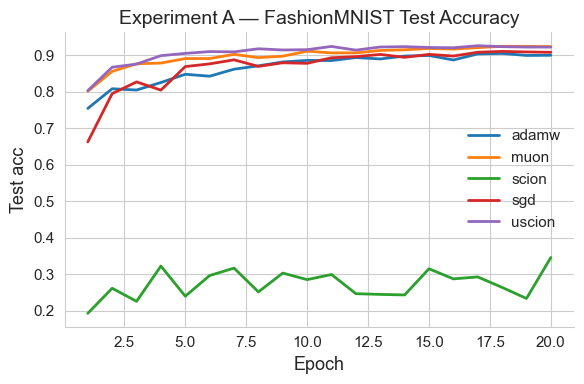

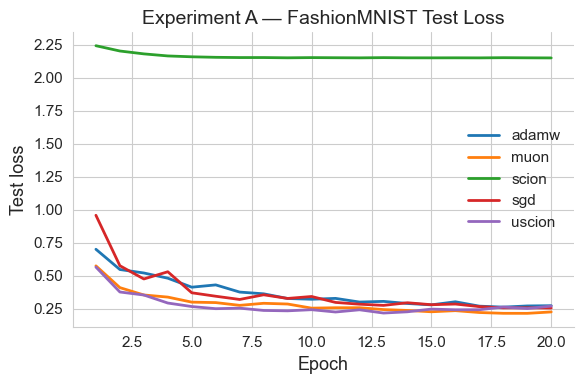

In [55]:
import seaborn as sns
import os 

sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "figure.figsize": (6, 4),
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def plot_metric(df, metric: str, title: str, save_path=None):
    fig, ax = plt.subplots()

    for opt_name, sub in df.groupby("optimizer"):

        ax.plot(
            sub["epoch"],
            sub[metric],
            label=opt_name
        )

    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.replace("_", " ").capitalize())
    ax.set_title(title)
    ax.legend(frameon=False)

    plt.tight_layout()

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


plot_metric(dfA, "test_acc",
            "Experiment A — FashionMNIST Test Accuracy",
            save_path="./images/expA_1_scion.png")

plot_metric(dfA, "test_loss",
            "Experiment A — FashionMNIST Test Loss",
            save_path="./images/expA_2_scion.png")

## Experiment B — SVHN hyperparameter transfer across widths

Protocol:
1) Choose a base width (e.g., 64) and tune γ (learning rate) on it.
2) Reuse the best γ for larger widths (e.g., 128, 256).
3) Compare how stable the transferred hyperparameter is (especially for SCION/uSCION vs AdamW/SGD).

In [56]:
set_seed(1)
svhn_train, svhn_test = get_svhn(batch_size=256)

In [65]:
def run_once_svhn(optim_name: str, lr: float, width: int, epochs: int = 5, wd: float = 0.0):
    model = SmallCNN(in_ch=3, num_classes=10, width=width).to(device)
    opt = make_optimizer(optim_name, model, lr=lr, wd=wd)
    df = fit(model, svhn_train, svhn_test, opt, epochs=epochs)
    df["optimizer"] = optim_name
    df["lr"] = lr
    df["width"] = width
    df["wd"] = wd
    return df

def run_once_fashion_mnist(optim_name: str, lr: float, width: int, epochs: int = 5, wd: float = 0.0):
    model = SmallCNN(in_ch=1, num_classes=10, width=width).to(device)
    opt = make_optimizer(optim_name, model, lr=lr, wd=wd)
    df = fit(model, train_loader, test_loader, opt, epochs=epochs)
    df["optimizer"] = optim_name
    df["lr"] = lr
    df["width"] = width
    df["wd"] = wd
    return df

Now we search for a good learning rate for each optimizer! 

In [ ]:
base_width = 64
grid = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]  # keep small; SVHN is harder

optimizers_B = ["adamw", "sgd", "scion", "uscion"]  # include muon if you want too

dfs = []
for opt_name in optimizers_B:
    for lr in grid:
        print(f"\n[SVHN tune] opt={opt_name} width={base_width} lr={lr}")
        dfs.append(run_once_svhn(opt_name, lr=lr, width=base_width, epochs=5, wd=1e-4 if opt_name=="adamw" else 0.0))

dfB_tune = pd.concat(dfs, ignore_index=True)
dfB_tune.tail()


[SVHN tune] opt=adamw width=64 lr=0.0001


/Users/tristan/Documents/dev/01_Cours_CS/06_ovo/SCION-method-review/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


ep 01 | tr 2.2435/0.1848 | te 2.2225/0.1959 | 19.2s
ep 02 | tr 2.2298/0.1919 | te 2.1945/0.2540 | 17.7s
ep 03 | tr 2.1376/0.2482 | te 2.0544/0.2892 | 18.6s
ep 04 | tr 2.0668/0.2680 | te 1.9900/0.3039 | 19.4s
ep 05 | tr 1.9941/0.2925 | te 1.9666/0.3069 | 19.0s

[SVHN tune] opt=adamw width=64 lr=0.0003
ep 01 | tr 2.2388/0.1890 | te 2.2167/0.1959 | 19.1s
ep 02 | tr 2.1156/0.2462 | te 1.9278/0.3299 | 18.3s
ep 03 | tr 1.8683/0.3358 | te 1.7717/0.3850 | 18.5s
ep 04 | tr 1.6882/0.4127 | te 1.5321/0.4833 | 19.1s
ep 05 | tr 1.5439/0.4730 | te 1.4015/0.5340 | 18.5s

[SVHN tune] opt=adamw width=64 lr=0.001
ep 01 | tr 2.2351/0.1919 | te 2.1846/0.2415 | 18.1s
ep 02 | tr 1.9462/0.3084 | te 1.6666/0.4416 | 18.3s
ep 03 | tr 1.5091/0.4848 | te 1.2984/0.5704 | 18.0s
ep 04 | tr 1.1667/0.6216 | te 0.9482/0.6968 | 18.1s
ep 05 | tr 0.9424/0.6999 | te 0.7678/0.7611 | 18.1s

[SVHN tune] opt=adamw width=64 lr=0.003
ep 01 | tr 2.2432/0.1868 | te 2.2185/0.1959 | 17.5s
ep 02 | tr 2.1024/0.2464 | te 1.7650/0.3692 

,epoch,train_loss,train_acc,test_loss,test_acc,sec,optimizer,lr,width,wd
95,1,2.536369,0.183395,2.227442,0.195874,17.568934,uscion,0.01,64,0.0
96,2,2.238319,0.189211,2.224426,0.195874,17.505083,uscion,0.01,64,0.0
97,3,2.240602,0.189211,2.226553,0.195874,17.448528,uscion,0.01,64,0.0
98,4,2.238584,0.189211,2.226094,0.195874,17.339014,uscion,0.01,64,0.0
99,5,2.238114,0.189211,2.226065,0.195874,17.361950,uscion,0.01,64,0.0


In [ ]:
# pick best lr by best test_acc at last epoch
last = dfB_tune.sort_values("epoch").groupby(["optimizer","lr","width"]).tail(1)
best = last.sort_values("test_acc", ascending=False).groupby("optimizer").head(1)
best_lrs = {row["optimizer"]: float(row["lr"]) for _, row in best.iterrows()}
best_lrs

{'adamw': 0.001, 'scion': 0.003, 'uscion': 0.0003, 'sgd': 0.001}

best lr found : {'adamw': 0.001, 'scion': 0.003, 'uscion': 0.0003, 'sgd': 0.001}

In [63]:
best_lrs = {'adamw': 0.001, 'scion': 0.003, 'uscion': 0.0003, 'sgd': 0.001}
best_lrs = {'adamw': 0.001, 'scion': 0.003, 'uscion': 0.03, 'sgd': 5e-2} # updated with uscion update 

In [66]:
widths = [16,24,32,40,48,56,64]
widths = [16,32,64]
dfs = []
optimizers_B = ["adamw", "sgd", "scion", "uscion"]
optimizers_B = ["adamw", "uscion"]
for opt_name in optimizers_B:
    lr = best_lrs[opt_name]
    for w in widths:
        print(f"\n[SVHN transfer] opt={opt_name} width={w} lr={lr}")
        dfs.append(run_once_fashion_mnist(opt_name, lr=lr, width=w, epochs=10, wd=1e-4 if opt_name=="adamw" else 0.0))

dfB = pd.concat(dfs, ignore_index=True)
dfB.tail()


[SVHN transfer] opt=adamw width=16 lr=0.001
ep 01 | tr 1.4937/0.4295 | te 0.9335/0.6890 | 4.7s
ep 02 | tr 0.9036/0.6711 | te 0.7433/0.7443 | 3.7s
ep 03 | tr 0.7702/0.7202 | te 0.6828/0.7610 | 3.7s
ep 04 | tr 0.7069/0.7426 | te 0.6522/0.7652 | 3.9s
ep 05 | tr 0.6618/0.7581 | te 0.6071/0.7848 | 3.9s
ep 06 | tr 0.6279/0.7703 | te 0.5701/0.7958 | 3.9s
ep 07 | tr 0.5972/0.7821 | te 0.5486/0.7998 | 3.9s
ep 08 | tr 0.5720/0.7912 | te 0.5297/0.8075 | 3.8s
ep 09 | tr 0.5581/0.7969 | te 0.5123/0.8110 | 3.9s
ep 10 | tr 0.5341/0.8058 | te 0.5040/0.8214 | 3.9s

[SVHN transfer] opt=adamw width=32 lr=0.001
ep 01 | tr 1.2701/0.5229 | te 0.8605/0.7004 | 5.7s
ep 02 | tr 0.7894/0.7124 | te 0.6869/0.7616 | 5.8s
ep 03 | tr 0.6566/0.7630 | te 0.5944/0.7889 | 5.8s
ep 04 | tr 0.5857/0.7863 | te 0.5199/0.8143 | 6.4s
ep 05 | tr 0.5314/0.8095 | te 0.4841/0.8289 | 6.5s
ep 06 | tr 0.4909/0.8238 | te 0.4709/0.8285 | 6.2s
ep 07 | tr 0.4589/0.8372 | te 0.4378/0.8425 | 6.0s
ep 08 | tr 0.4368/0.8435 | te 0.4088/0.8560

,epoch,train_loss,train_acc,test_loss,test_acc,sec,optimizer,lr,width,wd
55,6,0.243053,0.911700,0.273009,0.9030,12.414276,uscion,0.03,64,0.0
56,7,0.222310,0.919483,0.264923,0.9060,12.611693,uscion,0.03,64,0.0
57,8,0.205526,0.926733,0.229577,0.9168,12.376340,uscion,0.03,64,0.0
58,9,0.194595,0.928583,0.242381,0.9143,12.405852,uscion,0.03,64,0.0
59,10,0.180390,0.934433,0.233612,0.9173,14.083732,uscion,0.03,64,0.0


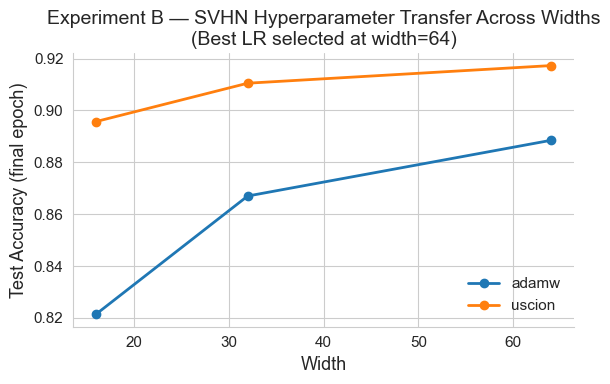

In [67]:
def plot_width_transfer(df, title, save_path=None):
    fig, ax = plt.subplots()

    for opt_name, sub in df.groupby("optimizer"):
        sub_last = (
            sub.sort_values("epoch")
               .groupby(["optimizer", "width"])
               .tail(1)
               .sort_values("width")
        )

        ax.plot(
            sub_last["width"],
            sub_last["test_acc"],
            marker="o",
            markersize=6,
            label=opt_name
        )

    ax.set_xlabel("Width")
    ax.set_ylabel("Test Accuracy (final epoch)")
    ax.set_title(title)
    ax.legend(frameon=False)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()

plot_width_transfer(
    dfB,
    "Experiment B — SVHN Hyperparameter Transfer Across Widths\n(Best LR selected at width=64)",
    save_path="./images/expB.png"
)

## Experiment C — Norm control: constrained (SCION/SCG) vs unconstrained (uSCION/uSCG)

We log per-epoch statistics of weight matrices, e.g.:
- spectral norm (approx via power iteration)
- Frobenius norm
and compare trajectories for SCION vs uSCION.

In [68]:
@torch.no_grad()
def power_iteration_spectral_norm(W: torch.Tensor, iters: int = 10, eps: float = 1e-12) -> float:
    # approximate ||W||_2 for 2D tensor
    if W.ndim != 2:
        return float("nan")
    m, n = W.shape
    v = torch.randn(n, device=W.device, dtype=W.dtype)
    v = v / (v.norm() + eps)
    for _ in range(iters):
        u = W @ v
        u = u / (u.norm() + eps)
        v = W.T @ u
        v = v / (v.norm() + eps)
    sigma = (u @ (W @ v)).abs().item()
    return sigma

@torch.no_grad()
def model_norm_stats(model: nn.Module) -> Dict[str, float]:
    specs = []
    fros = []
    for p in model.parameters():
        if p.ndim == 2:
            specs.append(power_iteration_spectral_norm(p))
            fros.append(torch.linalg.norm(p, ord="fro").item())
    out = {}
    if len(specs) > 0:
        out["spec_mean"] = float(np.mean(specs))
        out["spec_max"]  = float(np.max(specs))
        out["fro_mean"]  = float(np.mean(fros))
        out["fro_max"]   = float(np.max(fros))
    else:
        out["spec_mean"] = out["spec_max"] = out["fro_mean"] = out["fro_max"] = float("nan")
    return out

In [69]:
def fit_with_norm_logs(model, train_loader, test_loader, optimizer, epochs: int = 10):
    history = []
    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer, train=True)
        te_loss, te_acc = run_epoch(model, test_loader, optimizer, train=False)
        stats = model_norm_stats(model)
        dt = time.time() - t0
        row = dict(epoch=ep, train_loss=tr_loss, train_acc=tr_acc, test_loss=te_loss, test_acc=te_acc, sec=dt, **stats)
        history.append(row)
        print(f"ep {ep:02d} | te_acc {te_acc:.4f} | spec_max {stats['spec_max']:.3f} | {dt:.1f}s")
    return pd.DataFrame(history)

In [70]:
set_seed(2)
train_loader, test_loader = get_fashion_mnist(batch_size=256)

def run_expC(constrained: bool, lr: float = 5e-2, width: int = 64, epochs: int = 10):
    model = SmallCNN(in_ch=1, num_classes=10, width=width).to(device)
    opt = SCION(model.parameters(), lr=lr, momentum=0.9, constrained=constrained, radius=1.0, weight_decay=0.0)
    df = fit_with_norm_logs(model, train_loader, test_loader, opt, epochs=epochs)
    df["variant"] = "SCION(constrained)" if constrained else "uSCION(unconstrained)"
    df["lr"] = lr
    df["width"] = width
    return df

dfC1 = run_expC(constrained=True,  lr=3e-3, epochs=10)
dfC2 = run_expC(constrained=False, lr=3e-4, epochs=10)
dfC = pd.concat([dfC1, dfC2], ignore_index=True)
dfC.tail()

/Users/tristan/Documents/dev/01_Cours_CS/06_ovo/SCION-method-review/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


ep 01 | te_acc 0.1984 | spec_max 0.390 | 12.8s
ep 02 | te_acc 0.1894 | spec_max 0.317 | 13.1s
ep 03 | te_acc 0.3417 | spec_max 0.286 | 14.0s
ep 04 | te_acc 0.2541 | spec_max 0.273 | 13.5s
ep 05 | te_acc 0.2919 | spec_max 0.266 | 12.4s
ep 06 | te_acc 0.3158 | spec_max 0.262 | 13.2s
ep 07 | te_acc 0.3459 | spec_max 0.243 | 15.2s
ep 08 | te_acc 0.3029 | spec_max 0.251 | 13.9s
ep 09 | te_acc 0.2738 | spec_max 0.258 | 12.6s
ep 10 | te_acc 0.2410 | spec_max 0.252 | 12.5s
ep 01 | te_acc 0.2024 | spec_max 0.658 | 15.3s
ep 02 | te_acc 0.4057 | spec_max 0.677 | 14.9s
ep 03 | te_acc 0.2972 | spec_max 0.662 | 15.2s
ep 04 | te_acc 0.2765 | spec_max 0.702 | 15.8s
ep 05 | te_acc 0.3680 | spec_max 0.725 | 14.0s
ep 06 | te_acc 0.3758 | spec_max 0.735 | 13.4s
ep 07 | te_acc 0.4421 | spec_max 0.750 | 12.1s
ep 08 | te_acc 0.4552 | spec_max 0.764 | 12.2s
ep 09 | te_acc 0.4852 | spec_max 0.768 | 13.0s
ep 10 | te_acc 0.4842 | spec_max 0.784 | 12.0s


,epoch,train_loss,train_acc,test_loss,test_acc,sec,spec_mean,spec_max,fro_mean,fro_max,variant,lr,width
15,6,2.149342,0.306450,2.118536,0.3758,13.395145,0.734568,0.734568,1.876409,1.876409,uSCION(unconstrained),0.0003,64
16,7,2.094560,0.327550,2.057175,0.4421,12.055123,0.749921,0.749921,1.888608,1.888608,uSCION(unconstrained),0.0003,64
17,8,2.032300,0.349017,1.988944,0.4552,12.150062,0.764204,0.764204,1.900838,1.900838,uSCION(unconstrained),0.0003,64
18,9,1.965273,0.370150,1.917106,0.4852,13.028289,0.767725,0.767725,1.912943,1.912943,uSCION(unconstrained),0.0003,64
19,10,1.901177,0.385917,1.845312,0.4842,11.992856,0.784448,0.784448,1.924618,1.924618,uSCION(unconstrained),0.0003,64


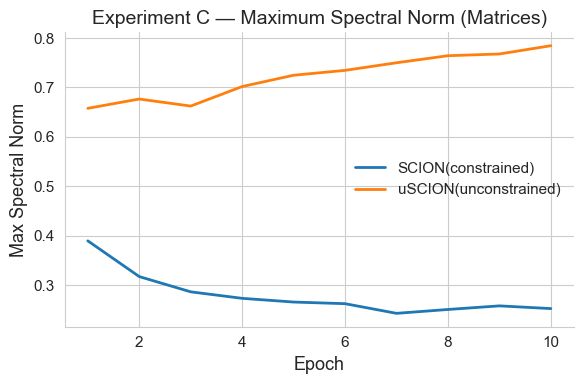

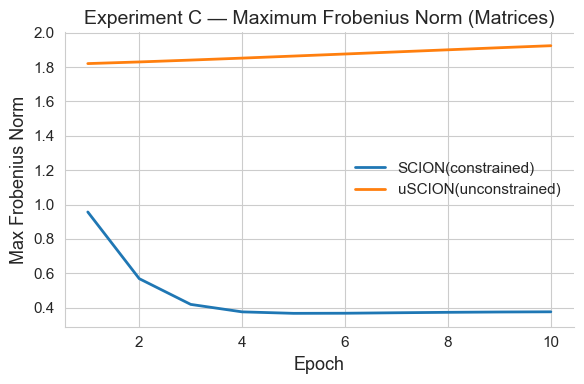

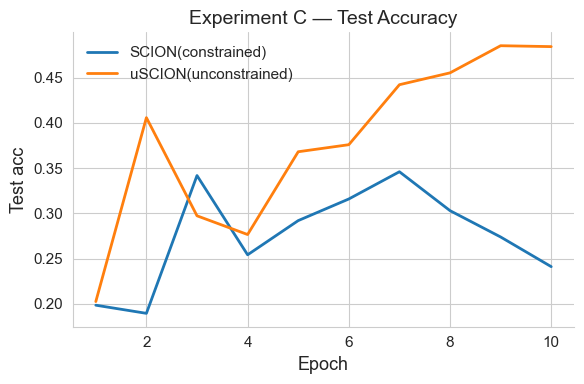

In [71]:
def plot_norm(df, col: str, title: str, save_path=None):
    fig, ax = plt.subplots()

    for name, sub in df.groupby("variant"):
        sub = sub.sort_values("epoch")
        ax.plot(
            sub["epoch"],
            sub[col],
            label=name
        )

    # Labels plus propres
    label_map = {
        "spec_max": "Max Spectral Norm",
        "fro_max": "Max Frobenius Norm"
    }

    ax.set_xlabel("Epoch")
    ax.set_ylabel(label_map.get(col, col))
    ax.set_title(title)
    ax.legend(frameon=False)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()

plot_norm(
    dfC,
    "spec_max",
    "Experiment C — Maximum Spectral Norm (Matrices)",
    save_path="./images/expC_1.png"
)

plot_norm(
    dfC,
    "fro_max",
    "Experiment C — Maximum Frobenius Norm (Matrices)",
    save_path="./images/expC_2.png"
)

plot_metric(
    dfC.rename(columns={"variant": "optimizer"}),
    "test_acc",
    "Experiment C — Test Accuracy",
    save_path="./images/expC_3.png"
)